In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

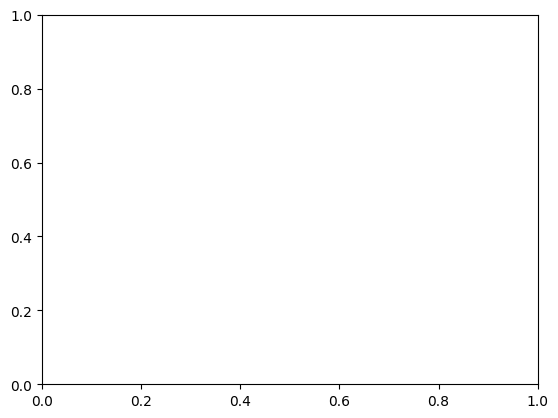

In [7]:
fig, ax = plt.subplots()
ax = [ax]




#parse data
def xml_to_datasets(data_file):
    tree = ET.parse(data_file)
    root = tree.getroot()
    datasets = []
    for dataset in root:
        currents = []
        current_std = []
        voltages = []
        voltage_std = []
        for entry in dataset:
            if entry.tag == 'Current':
                currents.append(float(entry[0].text))
                current_std.append(float(entry[1].text))
            elif entry.tag == 'Voltage':
                voltages.append(float(entry[0].text))
                voltage_std.append(float(entry[1].text))
        item = [[currents, current_std], [voltages, voltage_std]]
        datasets.append(item)
    return datasets

In [70]:
#plot data functions
def plot_iv(datasets):
    
    i = 0
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        if i % 10 == 0:
            ax[0].errorbar(voltages,currents,xerr = voltage_std, yerr = current_std, label = str("t="+str(i)), color = (i/len(datasets), 0, 1 - i/len(datasets)))
        else:
            pass
            #ax[0].errorbar(voltages,currents,xerr = voltage_std, yerr = current_std, color = (i/len(datasets), 0, 1 - i/len(datasets)))
        i+=1
    

#linear fit at steepest point to find threshold voltage
def plot_steepest_line(datasets):
    
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        max_derivative = 0
        max_derivative_index = 0
        for i in range(len(currents) - 1):
            if voltages[i + 1] - voltages[i] > 0.01:
                gradient = (currents[i + 1] - currents[i]) / (voltages[i + 1] - voltages[i])
                if gradient > max_derivative and currents[i] > 0:
                    max_derivative = gradient
                    max_derivative_index = i
                    gradient_err = gradient * np.sqrt((current_std[i] / currents[i])**2 + (voltage_std[i + 1] / voltages[i + 1])**2 + (voltage_std[i] / voltages[i])**2)
        f = lambda x : max_derivative * (x - voltages[max_derivative_index]) + currents[max_derivative_index]
        ax[0].errorbar(voltages, list(map(f,(voltages))),fmt="--", color = 'gray', label="Steepest Line")

        #error calculations
        x_intercept = (-currents[max_derivative_index] / max_derivative) + voltages[max_derivative_index]
        error = np.sqrt((currents[max_derivative_index] / max_derivative) * np.sqrt((current_std[max_derivative_index] / currents[max_derivative_index])**2 + (gradient_err / max_derivative)**2)**2 + voltage_std[max_derivative_index]**2)
        print("Steepest Line Threshold voltage: ", x_intercept, "+/-", error)

def calculate_derivative(x, y):
    derivative = np.array([])
    for i in range(1, len(y) - 1):
        if x[i + 1] - x[i - 1] > 0.02:
            gradient = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1])
            derivative = np.append(derivative, gradient)
    return list(derivative)

def calculate_smoothed_derivative(x, y):
    derivative = np.array([])
    r = 7
    NC = r * (r + 1) * (2 * r + 1) / 3
    for i in range(r, len(y) - r - 1):
        if x[i + 1] - x[i - 1] > 0.02:
            sum = 0
            for j in range(-r, r + 1):
                sum += y[i + j] * j
            derivative = np.append(derivative, (sum / NC) * (1/((x[i+1]-x[i])+(x[i]-x[i-1]))/2))
    return list(derivative)

#calculate and plot derivative
def plot_derivative(datasets):
    for dataset in datasets:
        currents = dataset[0][0]
        voltages = dataset[1][0]
        derivative = calculate_smoothed_derivative(voltages, currents)
        offset = int(-(len(derivative) - len(voltages)) / 2)
        voltages = voltages[offset:-offset]
        derivative2 = calculate_derivative(voltages, derivative)
        max_current = max(currents)
        scaled_derivative2 = np.array(derivative2) * (max_current / max(derivative2))
        offset = int(-(len(derivative2) - len(voltages)) / 2)
        voltages = voltages[offset:-offset]
        if len(voltages) != len(derivative2):
            voltages = voltages[:-1]
        ax[0].errorbar(voltages,scaled_derivative2,fmt="--", color = 'green', label = 'Derivative of $I_d$ w.r.t. V')
        index_max_derivative2 = derivative2.index(max(derivative2))
        max_derivative2_voltage = voltages[index_max_derivative2]
        error = max((voltages[index_max_derivative2 + 1]) - max_derivative2_voltage, max_derivative2_voltage - voltages[index_max_derivative2 - 1])
        print("Second Derivative Maximum: ", max_derivative2_voltage, "+/-", error)

#calculate and plot derivative calculation of threshold voltages over time
def plot_derivative_thresholds_time(datasets, times=None, colour = "green", label="2nd derivative method"):
    max_derivative2_voltages = []
    errors = []
    if times == None:
        times = range(0, len(datasets))
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        derivative = calculate_smoothed_derivative(voltages, currents)
        offset = int(-(len(derivative) - len(voltages)) / 2)
        voltages = voltages[offset:-offset]
        derivative2 = calculate_derivative(voltages, derivative)
        offset = int(-(len(derivative2) - len(voltages)) / 2)
        voltages = voltages[offset:-offset-1]
        index_max_derivative2 = derivative2.index(max(derivative2))
        max_derivative2_voltages.append(voltages[index_max_derivative2])
        errors.append(max((voltages[index_max_derivative2 + 1]) - voltages[index_max_derivative2], voltages[index_max_derivative2] - voltages[index_max_derivative2 - 1]))
    ax[0].errorbar(times, max_derivative2_voltages, yerr = errors, color = colour, label = label)

def plot_steepest_threshold_time(datasets, times=None, colour = "red", label="steepest line method"):
    x_intercepts = []
    errors = []
    if times == None:
        times = range(0, len(datasets))
    for dataset in datasets:
        currents = dataset[0][0]
        current_std = dataset[0][1]
        voltages = dataset[1][0]
        voltage_std = dataset[1][1]
        max_derivative = 0
        max_derivative_index = 0
        for i in range(len(currents) - 1):
            if voltages[i + 1] - voltages[i] > 0.01:
                gradient = (currents[i + 1] - currents[i]) / (voltages[i + 1] - voltages[i])
                if gradient > max_derivative and currents[i] > 0:
                    max_derivative = gradient
                    max_derivative_index = i
                    gradient_err = gradient * np.sqrt((current_std[i] / currents[i])**2 + (voltage_std[i + 1] / voltages[i + 1])**2 + (voltage_std[i] / voltages[i])**2)
        f = lambda x : max_derivative * (x - voltages[max_derivative_index]) + currents[max_derivative_index]
        #error calculations
        x_intercept = (-currents[max_derivative_index] / max_derivative) + voltages[max_derivative_index]
        error = np.sqrt(0.005**2 + (currents[max_derivative_index] / max_derivative) * np.sqrt((current_std[max_derivative_index] / currents[max_derivative_index])**2 + (gradient_err / max_derivative)**2)**2 + voltage_std[max_derivative_index]**2)
        x_intercepts.append(x_intercept)
        errors.append(error)
    ax[0].errorbar(times, x_intercepts, yerr = errors, color = colour, label=label)
    return [x_intercepts, errors]

In [71]:
#parse xml file
data_file = 'xml_Data/Ba133_uniradiated_linear.xml'#'xml_Data/arch5irradiated_3_slower.xml'
data_file2 = None

datasets = xml_to_datasets(data_file)
if data_file2 != None:
    datasets2 = xml_to_datasets(data_file2)

In [72]:
def fullplot_iv(datasets):
    ax[0].set_xlim(1.35, 2.85)
    ax[0].set_ylim(0, 0.00015)
    plot_iv(datasets)
    plot_derivative(datasets)
    plot_steepest_line(datasets)
    plt.title( "$I_d$ against $V_g$ for an unirradiated MOSFET")
    ax[0].set_ylabel('Id')
    ax[0].set_xlabel('Vg')
    plt.legend()
    return

Second Derivative Maximum:  1.874623 +/- 0.01599000000000017
Steepest Line Threshold voltage:  1.8402987500000003 +/- 0.0064211212235751125


<function matplotlib.pyplot.show(close=None, block=None)>

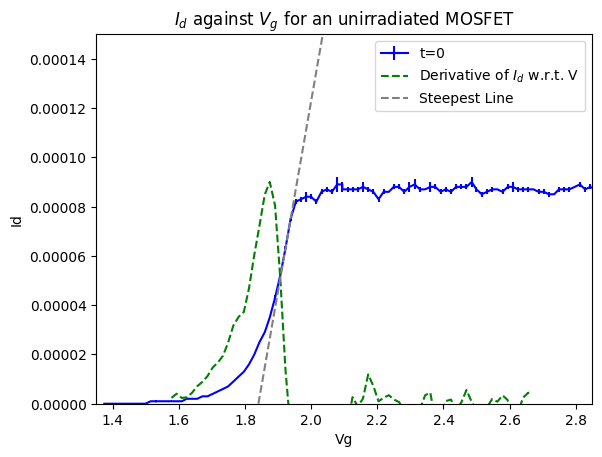

In [73]:
fig, ax = plt.subplots()
ax = [ax]
fullplot_iv(datasets)
plt.show